In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import itertools
import copy

from operator import itemgetter

np.random.seed(10) # pour une reproductibilité exacte

Nous nous focalisons ici sur l'algorithme permettant de trouver le k-core contenant les mots-clefs.

# Python

## Algorithme en Python "simple"

In [2]:
def elbow_python(sorted_scores):
    sorted_scores = [np.array(i) for i in sorted_scores]

    first_point = sorted_scores[0]
    last_point =sorted_scores[-1]
    distances = []

    for index,point in enumerate(sorted_scores):
        point= np.array(point)
        d=np.cross(last_point-first_point,point-first_point)/np.linalg.norm(last_point-first_point)
        distances.append(abs(d))

    if np.max(distances)>0:
        x_elbow=sorted_scores[np.argmax(distances)]
    else :
        x_elbow=sorted_scores[0]

    return x_elbow

# et le reste des fonctions permettant d'extraire les keywords si nous le voulions (mais nous nous
# focaliserons sur le fonction elbow. En décommentant, nous pouvons tester l'effet de la fonction elbow sur la
# totalité du graphe.

# def get_density(g):
#     e = g.number_of_edges()
#     v = g.number_of_nodes()

#     if v !=0:
#         density = abs(e)/(abs(v)*(abs(v)-1))
#         return density
#     else : 
#         return None

# def dens_method(g,k_core_decomp):
#     D=[]
#     for i in range(max(k_core_decomp.values())):
#         nodes_indexes = [k for k, v in k_core_decomp.items() if v >i]
#         g_small = g.subgraph(nodes_indexes)
#         D.append(get_density(g_small))
#     return elbow([i for i in enumerate(D)])[0]+1 # +1 as we started counting at zero

# def get_keywords(g):
#     k_core_decomp = nx.core_number(g) # replace by custom made function
#     k_core_value_of_keywords = dens_method(g,k_core_decomp)
#     keywords = [k for k, v in k_core_decomp.items() if v >= k_core_value_of_keywords]
#     return keywords


# Cython

In [3]:
%load_ext Cython

Pour la suite, et afin de pouvoir appliquer Cython de façon approfondie sur une tâche simple, nous nous focalisons sur la fonction permettant de trouver le coude (`elbow_python` dans l'exemple Python "simple")

## Cython naïf

Une première approche est de simplement rajouter `%% Cython` au début de la cellule (sans changer autre
chose).

In [4]:
%%cython
import numpy as np
from libc.math cimport sqrt

def naive_cython_elbow(sorted_scores):
    sorted_scores = [np.array(i) for i in sorted_scores]

    first_point = sorted_scores[0]
    last_point =sorted_scores[-1]
    distances = []

    for index,point in enumerate(sorted_scores):
        point= np.array(point)
        d=np.cross(last_point-first_point,point-first_point)/np.linalg.norm(last_point-first_point)
        distances.append(abs(d))

    if np.max(distances)>0:
        x_elbow=sorted_scores[np.argmax(distances)]
    else :
        x_elbow=sorted_scores[0]

    return x_elbow

## Réecriture de fonctions en C

A partir du code existant, nous avons crée des fonctions `cdef`, permettant d'exécuter du code en C. Ceci a été un défi, étant donné qu'aucun de nous deux n'avait travaillé sur du C auparavant.
Nous avons aussi déclaré les types de variables, et replacé les fonctions Python (`def`) en fonction mixtes `cpdef`, qui permettent de fonctionner en C lors que l'on utilise les types fondamentaux de C, et passer en Python sinon.

In [5]:
%%cython
import cython
import numpy as np
from libc.math cimport sqrt

cdef float cross_prod_vect( first_point, last_point,  point):
    cdef float Ax = (last_point[0] - first_point[0])
    cdef float Ay = (last_point[1]-first_point[1])
    cdef float Bx = (point[0]-first_point[0])
    cdef float By = (point[1]-first_point[1])
    cdef float result= Ax*By-Ay*Bx
    cdef float norm = sqrt(Ax*Ax+Ay*Ay)
    return result/norm

cpdef cdef_elbow(sorted_scores):
    cdef int elbow_point
    cdef double[:] first_point = sorted_scores[0]
    cdef double[:] last_point = sorted_scores[-1]
    cdef int i # pour optimiser la boucle
    cdef double[:] Y = np.zeros(len(sorted_scores))

    for i in range(len(sorted_scores)):
        point = sorted_scores[i]
        d = cross_prod_vect(first_point,last_point,point)
        Y[i]=abs(d)
        
    if np.max(Y)>0:
        x_elbow=sorted_scores[np.argmax(Y)]
    else :
        x_elbow=sorted_scores[0]

    return x_elbow

## Ajout des memoryviews

Étant donné que nous devons travailler sur des array, un élément qui diminue la performance est l'utilisation de \texttt pour accéder aux données. Afin d'éviter cela, `Cython` propose les Memorviews, qui sont des strcutres C qui pointent vers les arrays Numpy.

Nous pouvons les voir dans notre fonction par exemple dans des déclarations comme `cdef double[:] first_point`.

In [6]:
%%cython
import cython
import numpy as np
from libc.math cimport sqrt

cdef float cross_prod_vect(double[:] first_point, double[:] last_point,  double[:] point):
    cdef float Ax = (last_point[0] - first_point[0])
    cdef float Ay = (last_point[1]-first_point[1])
    cdef float Bx = (point[0]-first_point[0])
    cdef float By = (point[1]-first_point[1])
    cdef float result= Ax*By-Ay*Bx
    cdef float norm = sqrt(Ax*Ax+Ay*Ay)
    return result/norm
    
cpdef c_elbow_memoryviews(double[:, :] sorted_scores):

    cdef int elbow_point
    cdef double[:] first_point = sorted_scores[0]
    cdef double[:] last_point = sorted_scores[-1]
    cdef int i # pour optimiser la boucle
    cdef double[:] Y = np.zeros(len(sorted_scores))

    for i in range(len(sorted_scores)):
        point = sorted_scores[i]
        d = cross_prod_vect(first_point,last_point,point)
        Y[i]=abs(d)
        
    if np.max(Y)>0:
        x_elbow=sorted_scores[np.argmax(Y)]
    else :
        x_elbow=sorted_scores[0]
        
    return x_elbow


## Désactivation des vérifications

Enfin, la documentation de `Cython` précise que lors d'un `lookup` sont effectué deux checks (au moins):
-  Vérification qu'il n'y ait pas d'indices négatifs (et si c'est le cas ils sont traités de façon appropriée ensuite).
-  Contrôle des limites (*bounds checking*).

Éliminer ces deux checks est rapide via des décorateurs, mais pour cela il a fallu auparavant modifier légèrement le code pour ne plus nécessiter d'indices négatifs (ce qui était le cas et a été changé).

In [7]:
%%cython
import cython
import numpy as np
from libc.math cimport sqrt

cdef float cross_prod_vect(double[:] first_point, double[:] last_point,  double[:] point):
    cdef float Ax = (last_point[0] - first_point[0])
    cdef float Ay = (last_point[1]-first_point[1])
    cdef float Bx = (point[0]-first_point[0])
    cdef float By = (point[1]-first_point[1])
    cdef float result= Ax*By-Ay*Bx
    cdef float norm = sqrt(Ax*Ax+Ay*Ay)
    return result/norm 

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef c_elbow_noboundscheck_nowraparound(double[:, :] sorted_scores):
    cdef int elbow_point
    cdef int N = sorted_scores.shape[0]
    cdef double[:] first_point = sorted_scores[0]
    cdef double[:] last_point = sorted_scores[N-1]
    cdef int i # pour optimiser la boucle
    cdef double[:] Y = np.zeros(N)

    for i in range(N):
        point = sorted_scores[i]
        d = cross_prod_vect(first_point,last_point,point)
        Y[i]=abs(d)
        
    if np.max(Y)>0:
        x_elbow=sorted_scores[np.argmax(Y)]
    else :
        x_elbow=sorted_scores[0]

    return x_elbow

## Déclaration des *numpy arrays* comme  contigus

Déclarer les arrays comme contigus}
Nous pouvons déclarer les arrays comme contigus afin d'accéder plus rapidement, en les déclarant par exemple `c_elbow_continous(double[:, ::1])` dans la déclaration de la fonction (noter le `::1`).

In [8]:
%%cython
import numpy as np
from libc.math cimport sqrt
import cython

cdef float cross_prod_vect(double[::1] first_point, double[::1] last_point,  double[::1] point):
    cdef float Ax = (last_point[0] - first_point[0])
    cdef float Ay = (last_point[1]-first_point[1])
    cdef float Bx = (point[0]-first_point[0])
    cdef float By = (point[1]-first_point[1])
    cdef float result= Ax*By-Ay*Bx
    cdef float norm = sqrt(Ax*Ax+Ay*Ay)
    return result/norm

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef c_elbow_continous(double[:, ::1] sorted_scores):
    cdef int elbow_point
    cdef int N = sorted_scores.shape[0]
    cdef double[::1] first_point = sorted_scores[0]
    cdef double[::1] last_point = sorted_scores[N-1]
    cdef int i # pour optimiser la boucle
    cdef double[::1] Y = np.zeros(N)

    for i in range(N):
        point = sorted_scores[i]
        d = cross_prod_vect(first_point,last_point,point)
        Y[i]=abs(d)

    if np.max(Y)>0:
        x_elbow=sorted_scores[np.argmax(Y)]
    else :
        x_elbow=sorted_scores[0]

    return x_elbow


# Calcul parallèle

Ainsi, dans la boucle qui calcule la distance d'un point à la ligne (premier point, dernier point), nous enlevons le GIL *Global Interpreter Lock* qui empêcherait la parallélisation. Ceci a des conséquences concrètes sur notre code, étant donné que nous ne pouvons plus utiliser de variable ou fonction Python à l'intérieur du `nogil`. Une fois le GIL desactivé nous pouvons effectuer les calculs en parallèle.

Ce procédé est à priori simple à l'aide de `Cython` et `OpenMP` (même si le bebugging demeure parfois complexe et chronophage).
Nous avons simplement utilisé deux fonctionnalités issues de `cython.parallel` :  `with nogil:` avant la boucle, et `prange` à l'intérieur de celle-ci. Remarquons qu'utiliser `with nogil, parallel():` et un `range` "normal" semble donner aussi des résultats convenables.

D'un point de vue technique, cette modification de notre boucle permet à `OpenMp` d'ouvrir un *Thread Pool* et distribuer le calcul.

In [9]:
%%cython  --compile-args=-fopenmp  --link-args=-fopenmp
import numpy as np
from libc.math cimport sqrt
import cython
from cython.parallel import prange,parallel,prange


@cython.boundscheck(False)
@cython.wraparound(False)
cpdef c_elbow_parallel(double[:, ::1] sorted_scores):
    cdef int elbow_point
    cdef int N = sorted_scores.shape[0]
    cdef double[::1] first_point = sorted_scores[0]
    cdef double[::1] last_point = sorted_scores[N-1]
    cdef int i # pour optimiser la boucle
    cdef double[::1] Y = np.zeros(N)
    with nogil, parallel():
        for i in prange(N):
            #on pourrait calculer à l'avance les opérations entre first/last point, mais étant donné
            #que ceci a été fait à toutes les fonctions, ça ne change pas la comparaison
            Y[i]= ((last_point[0] - first_point[0])*(sorted_scores[i][1]-first_point[1])-(last_point[1]-first_point[1])*(sorted_scores[i][0]-first_point[0]))/sqrt((last_point[0] - first_point[0])*(last_point[0] - first_point[0])+(last_point[1]-first_point[1])*(last_point[1]-first_point[1]))
    
    if np.max(Y)>0:
        x_elbow=sorted_scores[np.argmax(Y)]
    else :
        x_elbow=sorted_scores[0]

    return x_elbow

In [10]:
#vérification que les résultats soient bons pour un exemple assez grand (pour que ça ne puisse pas être un hasard)
D = np.random.rand(10**3,)
final_array = np.array([i for i in enumerate(D)])
elbow_python(final_array)[0] ==naive_cython_elbow(final_array)[0] ==cdef_elbow(final_array)[0] ==c_elbow_memoryviews(final_array)[0] ==c_elbow_noboundscheck_nowraparound(final_array)[0] ==c_elbow_continous(final_array)[0]==c_elbow_parallel(final_array)[0]

True

# Comparaison

In [11]:
from timeit import timeit
from tqdm import tqdm

array_len_range= range(1,7)
functions = ['elbow_python','naive_cython_elbow','cdef_elbow','c_elbow_memoryviews','c_elbow_noboundscheck_nowraparound','c_elbow_continous','c_elbow_parallel']
functions_arrays=[(i,[]) for i in functions]

for i in tqdm(array_len_range):
    num_iter = 5-min(i,3)
    D = np.random.rand(10**i,)

    for function,array in functions_arrays:

        final_array = np.array([i for i in enumerate(D)])
        time = timeit(str(function + '(final_array)'), number=num_iter, globals=globals())/num_iter
        array.append(time)

100%|██████████| 6/6 [06:33<00:00, 65.51s/it] 


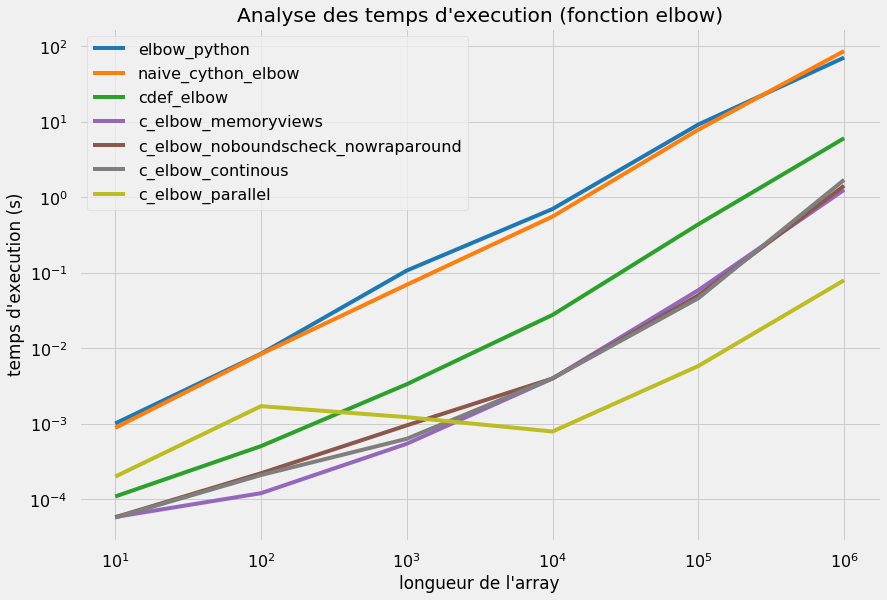

In [12]:
from matplotlib import pyplot as plt

# fonctions pour les plots
plt.style.use(['seaborn-poster','fivethirtyeight'])
fig, ax = plt.subplots()
NUM_COLORS = len(functions_arrays)
cm = plt.get_cmap('tab10')
ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


x = [10**i for i in array_len_range]

for i,(function,array) in enumerate(functions_arrays):
    ax.plot(x, array,label=function)

ax.set_title("Analyse des temps d'execution (fonction elbow)")
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')

plt.xlabel ("longueur de l'array")
plt.ylabel ("temps d'execution (s)")
plt.show()